# Project

__Project website:__ https://share.streamlit.io/blue56/socialgraphwebsite/main

## Table of Contents
- [__Part 0: Motivation__](#0.)
- [__Part 1: Data gathering and processing__](#1.)
    - [Data needs](#1.1.)
    - [Data cleaning](#1.2.)
    - [Data preprocessing](#1.3.)
- [__Part 2: Basic network statistics__](#2.)
    - [Building the network](#2.1.)
    - [Degree Distribution](#2.2.)
- [__Part 3: Tools, theory and analysis__](#3.)
    - [Text Processing](#3.1.)
    - [Analyses](#3.2.)
        - [Function for VADER](#3.2.1.)
        - [Analysis 1](#3.2.2.)
        - [Analysis 2](#3.2.3.)
        - [Analysis 3](#3.2.4.)
        - [Analysis 4](#3.2.5.)
        - [Word clouds](#3.2.6.)
- [__Part 4: Discussion__](#4.)
- [__Part 5: Contribution__](#5.)
- [__Part 6: References__](#6.)

<a id='0.'></a>
## Motivation

* Friends is a sitcom show produced during 1994 and 2004 that has become very popular across the globe being watched over 100 billions of times worldwide. Even now, 17 years after the show has ended, televisions and streaming services are still broadcasting the show and fans can't get enough of it. Given all its popularity and theories about the show that have been discussed over the years, network and data science are giving us the tools to attempt to analyze the relationships and the sentiment of the show from a scientific angle. 

* Thereby, by collecting data about the fictional characters from wiki fandom along with the episode scripts, the team has embarked on a journey of discovering perhaps things that have not been previously known about the show. For example, one questions super fans are usually having endless debates on is who is the most important character in the show? 


* The goal of this project is to offer a more in-depth analysos of the Friends universe by using network science through network science. Moreover sentiment analysis will be used to describe the personality of the individual characters as well as the relationship between them. Ultimately we would attempt to reveal with our project if the directors of the show have an influence on the imdb rating, if there exists a difference in the sentiment the characters express towards each other or if the sentiment of the show changes over time as the characters get older and their problems become more realistic. 

* Moreover using centrality measures we would try to offer an answer to the question, who is the most central character of the show.

* Term frequency and inverse document frequency will be used to determine which are the words that characterize the main characters the best. 

* With the use of data visualization the team will aim to showcase what has been discovered about the show in an easy and understandable manner that can make other fans of the show or people who have never watched it understand the most important aspects of the character's relationship and personalities. 

<a id='1.'></a>
## Data gathering and processing

We have moved most of the data gathering and processing code to a seperate notebook named "Data_Gathering_and_Processing". We have done that to improve the readablity of the code that centers around the analysis. 

<a id='1.1.'></a>
### Data needs

We need data to be able to do the analyzes that we planned to do. Below is a list of the data that we needed and a description of the way that we obtained the data.

- Information about Friends characters. Obtained using the Fandom API. Regex was used to extract the needed information.

- Relationship between characters. If one character is mentioned on another characters Fandom wiki page. Obtained using the Fandom API. Regex was used to extract the needed information.

- Relationship between characters if one character mentions another character in a transscript sentence. Transscripts was obtained by downloading transcript files from a GitHub repo. Transscripts was in html format, with a non consistent syntax. Regex was used to extract the neeed information. Two different regex patterns was used.

- Name of Friends seasons. Extracted from the transscript files.

- Name of episodes and the relation to seasons. Extracted from the transscript files.

- IMDb rating of each episode. Obtained using IMDbPy package.

- Director of episodes. This information was obtained via Wikidata. It was extracted as Linked Data in RDF format by using SPARQL as the query language.

<a id='1.2.'></a>
### Data cleaning

The data has been cleaned in several ways. On example is the names of the friends. Some places the full name is used to referer to a friend other places only the first name is used. There are also some misspelling of names. E.g. Monica was misspelled MOnica. We have hard code rules where needed.

<a id='1.3.'></a>
### Data preprocessing

Data has been preprocessed in several ways. However there is pattern that is used again and agin in the notebook. We use DataFrames to preprocess and temporary store data. We also heavily use csv files to store the preprocessed data. We main do that for two reasons:

1. The csv files is used for our website. The website has to resonable response times.
2. Keep the notebook and related files as self contained as possibly. 

We read the csv files and place the content into different data structures:

- Network graph. It consists of the characters as nodes and the edges represents relationship between characters. A relationship is present if one character is mentioned on another characters wiki page.

- DataFrame containing transscripts of each episode.

- DataFrame that consists of three columns:

    - The character that tells a story line.
    - The character that is mentioned in the story line.
    - The story line it self.

- DataFrame containing metadata about the episodes. Director for each episode, the IMdB rating of each episode and finally which season each episode belong to.

<a id='2.'></a>
## Network statistics

__Dataset stats discussion__

Here is a summary of the dataset statistics:

- Number of Friends seasons: 10
- Total number of Friends episodes: 236
- Number of characters: 423
- Number of edges used for network: 2183
- The number of male characters is 194, the number of female characters 194, and 45 characters whose gender is not known - a very even gender distribution. 
- The transscripts consists of 46657 transscript story lines.

The network graph is a bit small and we have therefore tried to do some more indepth analysis. The transcripts plays an important part in these in depth analysis. The in depth analysis centers around sentiment analysis of the episodes transscripts and combine metadata about the episodes, e.g. the IMDb ratings.




### Import statments

This section contains all the import statements for the notebook. A requriments.txt file is also provided with specific package versions.

In [1]:
# Import nessary packages: 
import numpy as np 
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from os import listdir
from os.path import isfile, join
from wordcloud import WordCloud
from operator import itemgetter
import random
import os
from fa2 import ForceAtlas2
from matplotlib.pyplot import figure
import powerlaw
import networkx.algorithms.community as nx_comm
import json
import collections
from nltk.tokenize import sent_tokenize,word_tokenize, RegexpTokenizer 
from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import itertools
import urllib
import imdb
import json
from urllib.parse import quote
import ast
from SPARQLWrapper import SPARQLWrapper, JSON
from fuzzywuzzy import fuzz
import operator
import csv
from matplotlib.pyplot import figure
from gensim.models import LdaModel
from pprint import pprint
from scipy import stats
import pprint
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

<a id='2.1.'></a>

### Building the network

In [2]:
#get nodes and edges 
nodes = pd.read_csv('nodes.csv')
friends_links = pd.read_csv('friends_links.csv')
edges = list(zip(friends_links.CH_1, friends_links.CH_2))

In [3]:
# graph creation 
H = nx.Graph()
H.add_nodes_from(nodes)
H.add_edges_from(edges)

<a id='2.2.'></a>
### Degree distributions 

In [4]:
#get all sentiment values 
degrees = [i[1] for i in list(H.degree)]
# get hist values and edges 
hist, bin_edges = np.histogram(degrees)

<>:7: DeprecationWarning: invalid escape sequence \i
<>:7: DeprecationWarning: invalid escape sequence \i
C:\Users\jacob\AppData\Local\Temp/ipykernel_14128/3853334380.py:7: DeprecationWarning: invalid escape sequence \i
  plt.title('$\it{F}$•$\it{R}$•$\it{I}$•$\it{E}$•$\it{N}$•$\it{D}$•$\it{S}$ - Degree Distribution',fontsize=18)


(0.0, 110.0)

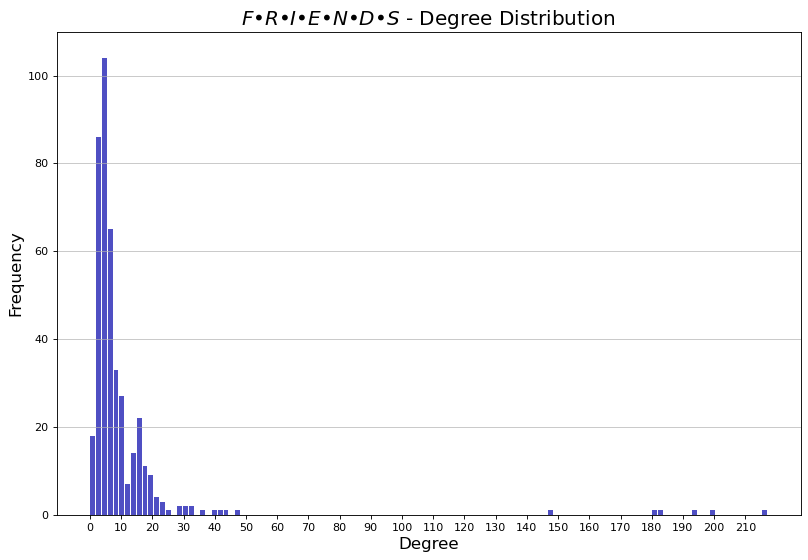

In [5]:
figure(figsize=(12, 8), dpi=80)
n, bins, patches = plt.hist(x=degrees, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Degree',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('$\it{F}$•$\it{R}$•$\it{I}$•$\it{E}$•$\it{N}$•$\it{D}$•$\it{S}$ - Degree Distribution',fontsize=18)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.xticks(np.arange(min(degrees), max(degrees)+1, 10))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

* The degree distribution shows that there is a small number of characters with a high degree while most of the characters have a small degree, meaning that they have not formed a lot of connections with other characters. We are expecting that the characters with a high degree are the protagonists of the show - namely, Rachel, Monica, Phoebe, Ross, Chandler and Joey! 

<a id='3.'></a>
## Tools, theory and analysis 
* Talk about how you've worked with text, including regular expressions, unicode, etc.
* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
* How did you use the tools to understand your dataset?

<a id='3.1.'></a>
### Text processing

We have had the need to work with semiunstructed text different places. Most notablely in regard to the transscripts. The transscripts seems to have been written over a longer periode of time, maybe at the same time as the different seasons was aired. The HTML features used for the transscript markup has changed over time and we had to handle this. We created two regex patterns to extract the story lines from the transscripts. The two regex patterns can be found above this block. The patterns are explained here:

_Regex pattern 1_

```
<b>(?P<name>[\w]+):<\/b>[ ]*(?P<content>[\w\s\\n\'.,?$!]+)
```


The pattern first looks for the html tag ```<b>``` after that it matches a capture group to capture the name of the character saying the story line. This is followed by the characters :<\/b> and a variable number of spaces, represented with this subpattern ```[ ]*``` Finally the other capture group capture the content of the story line. The content of the content capture group has to match the characters in the list ```[\w\s\\n\'.,?$!]```

_Regex pattern 2_

This pattern uses the same functionality as regex pattern 1. However it looks for some different html tags.

<a id='3.2.'></a>

### Analyses 

<a id='3.2.1.'></a>
#### Useful function which computes VADER sentiment 
* Function to compute the sentiment of a given dictionary where keys of the dictionary are instance for which the sentiment will be computed and the values in the dictionary are lists of sentence tokens 

In [6]:
analyzer = SentimentIntensityAnalyzer()

def compute_vader_sentiment(dictionary_of_sentences):
    
    sentiment_vals = {}
    for character in list(dictionary_of_sentences.keys()):
        
        list_of_scores = []
        #loop through list of sentences and compute a compund score of each sentence
        for sent in dictionary_of_sentences[character]:
            list_of_scores.append(analyzer.polarity_scores(sent)['compound'])
        if len(list_of_scores)> 10:
            sentiment_vals[character] = sum(list_of_scores)/len(list_of_scores)
            
    
    return sentiment_vals 

<a id='3.2.2.'></a>
#### Analysis 1: Understand Characters Sentiment

* This analysis will attempt to investigate, using story lines from the show's script, what is the sentiment of the characters that own storylines in the show as well as the distribution of the sentiment in the show among character. 
* The tool that will be used to compute the sentiment of the show is VADER analyzer which is available as a python library. 
* Sentiment analysis works by detecting polarity which can be a positive or negative opinion in a text. 
* Vader analyzer is a model that is used in sentiment analysis as it can detect polarity and the strength of the emotion in a given text. Vader is also intelligent enough to understand basic contexts such as 'did not love', as a negative statement. 
* The vader analyzer ouputs a compound score which can split sentiment in 3 different categories: positive, negative and neutral. 
* The text will be tokenized into a list of sentences. To obtain a fair coumpound average of the sentiment score, only characters with a number of story lines higher than 10 will be considered. 

In [7]:
#get lines from file 
lines = pd.read_csv('lines.csv').reset_index()
lines = lines[['Character','Lines']]

In [8]:
#extract lines from Lines column from dataframe and 
#convert to list 
sent_from_dialogue = {}
for i in range(0,len(lines)):
    sent_from_dialogue[lines.Character[i]] = ast.literal_eval(lines.Lines[i])

In [9]:
# remove dict entry where k == 'MOnica' and assign the lines to key 'Monica'
#repeat for Rache and Chandlers 
for k in list(sent_from_dialogue.keys()):
    
    if k == 'MOnica':sent_from_dialogue['Monica'].extend(sent_from_dialogue['MOnica'])
    elif k =='Rache':sent_from_dialogue['Rachel'].extend(sent_from_dialogue['Rache'])
    elif k == 'Chandlers': sent_from_dialogue['Chandler'].extend(sent_from_dialogue['Chandlers'])
sent_from_dialogue.pop('MOnica',None)
sent_from_dialogue.pop('Rache',None)
sent_from_dialogue.pop('Chandlers',None)

['Dude, none of this is']

In [10]:
#apply vader sentiment function 
characters_sentiment = compute_vader_sentiment(sent_from_dialogue)
sorted_characters_sentiment = {k: v for k, v in sorted(characters_sentiment.items(), key=lambda item: item[1],reverse=True)}

In [11]:
print(f'The five most positive characters are:' + str({k: sorted_characters_sentiment[k] for k in list(sorted_characters_sentiment)[:5]}))
print(f'The five most negative characters are:' + str({k: sorted_characters_sentiment[k] for k in list(sorted_characters_sentiment)[-5:]}))

The five most positive characters are:{'Shelley': 0.22006470588235297, 'Donny': 0.21667272727272727, 'Katie': 0.2156515151515152, 'Mindy': 0.20208965517241376, 'Ronni': 0.19625769230769233}
The five most negative characters are:{'Stanley': -0.01821666666666667, 'Kori': -0.03661538461538461, 'Julio': -0.04649999999999998, 'Luisa': -0.05979523809523809, 'Precious': -0.06340555555555556}


__Sentiment histogram__ 

In [12]:
#get all sentiment values 
sentiment_array = list(characters_sentiment.values())
# get hist values and edges 
hist, bin_edges = np.histogram(sentiment_array)

In [13]:
df_char_sentiment = pd.DataFrame()
df_char_sentiment['Character'] = list(characters_sentiment.keys())
df_char_sentiment['Sentiment'] = list(characters_sentiment.values())
df_char_sentiment.to_csv('characters_sentiment.csv')

(0.0, 30.0)

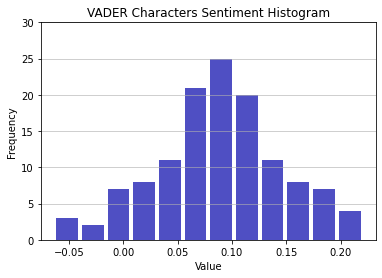

In [14]:
n, bins, patches = plt.hist(x=list(characters_sentiment.values()), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('VADER Characters Sentiment Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

__Findings__ 

* According to VADER the five most positive characters are Shelley, Donny, Katie, Mindie and Ronnie - all having an average compound score above the thresold of positivity, which is 0.05. Moreover the most negative characters are Precious, Luisa, Julio, Kori and Stanley, all having a compound score below zero. However according to VADER only scores below -0.05 indicate negativity and therefore the conclusion is that out of the five characters, only Luisa and Precious can be considered as characters with a negative sentiment.
*  The sentiment of the six main characters is as follows: Rachel: 0.099, Phoebe 0.100, Monica 0.084, Ross 0.087, Chandler: 0.089, 0.091. One can consider all six characters as being positive as all of them have an average compound score of over 0.05. It is concluded that Phoebe is the most positive character and Monica is the least positive one while Joey is the most positive main male character.Phoebe and Rachel have a very similar sentiment score. 
* The sentiment score distribution, as observed in the histogram lays in the interval -0.05 and 0.20. While it has been found that only 2 characters can be categorizes as negative, if we look at the histogram we can observe that approximately 30 characters out of the 127 characters who had more than 10 story lines in the show transmit a neutral sentiment. The rest of the characters - approx 100 - are concluded to be positive, but not extremely positive since none of them have a sentiment that is very close to 1, which is the higher boundary of the sentiment score interval. 

<a id='3.2.3.'></a>

#### Analysis 2: Study effect of the director on the imdb score 
* To understand if the various directors of the show have an influence on the imdb score a one-way ANOVA statistical test is going to be used. The one way anova test has the capacity to detect wheter there exists a statistically significant difference between the means of two or more independent groups. 
* The ANOVA test required that there exists an independent and a dependent variable. In this case, the independent variable is the director of the show while the dependent variable is the imdb score. 
* The test returns a p-value that if below the significant level of 0.05 would show that there exists a significant difference between the group means.  
* The ANOVA test is a parametric test that is sensitive to any abnormalities in the data and therefore it must be ensured that prior to carrying the test the normality assumptions must be fulfilled. 

__Normality assumptions__
* dependent variable is continuous - imbdb score cont variable 
* independent variable consists of two or more categories - yes there are 17 directors in total 
* independence in observations - it is assumed so 
* there should be no outliers - all data points outside of the interquantile range will be removed 
* dependent variable must be normally distributed for each category of the independent variable - DONE
* homogeneity of variances - test using Levene's test for homogeneity of variances. If assumption failed, use Welch anova

In [15]:
## get data
episodes_data = pd.read_csv('episodes.csv')
ratings_and_directors = episodes_data.copy()[['Rating','Director']]
ratings_and_directors = ratings_and_directors.dropna(axis=0, subset=['Director']).reset_index()

In [16]:
#outliers removal 
Q1 = ratings_and_directors['Rating'].quantile(0.25)
Q3 = ratings_and_directors['Rating'].quantile(0.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5*IQR 
higher_b = Q3 + 1.5*IQR
#remove all data points outside the interquantile range 
df_wo_outliers = ratings_and_directors[(ratings_and_directors['Rating'] >= lower_b) & (ratings_and_directors['Rating']<=higher_b)]

In [17]:
directors = []
for d in list(df_wo_outliers['Director'].unique()):
    #get list of directors who directed more than 20 episode 
    if len(df_wo_outliers[ratings_and_directors.Director == d]) >= 20:
        directors.append(d)
for director in directors:
    _, p_val = stats.normaltest(df_wo_outliers[df_wo_outliers.Director == director]['Rating'])
    if p_val > 0.05:
        print('Normality assumption not violated') # normality assumptions not violated 
    elif p_val < 0.05:
        print('Normality assumption VIOLATED'+ str(director))

Normality assumption not violated
Normality assumption not violated


C:\Users\jacob\AppData\Local\Temp/ipykernel_14128/2555536530.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df_wo_outliers[ratings_and_directors.Director == d]) >= 20:


In [18]:
all_directors = [x.replace(' ','_') for x in df_wo_outliers.Director.unique()]
all_dfs = []
for x in all_directors:
    globals()[f"df_{x}"] = df_wo_outliers[df_wo_outliers['Director'] == x.replace('_',' ')].reset_index()
    all_dfs.append(globals()[f"df_{x}"])
#remove all dataframes with length of less than 20 data points 
#since ANOVA requires a minimum of 20 data points in each group to draw a conclusion
all_dfs_v3 = [x for x in all_dfs if len(x)>=20]

In [19]:
#homogeneity of variance fulfilled 
from scipy.stats import levene
stat, p = levene(all_dfs_v3[0]['Rating'], all_dfs_v3[1]['Rating'])
if p>0.05: print('Homogeneity of variance assumption fulfilled')
else: print('Homogeneity of variance assumption not fulfilled')

Homogeneity of variance assumption fulfilled


__ANOVA TEST__

In [20]:
# ANOVA test 
from scipy.stats import f_oneway
_, p_val_anova = f_oneway(all_dfs_v3[0]['Rating'],all_dfs_v3[1]['Rating'])
if p_val_anova > 0.05:
    print('The group means are not different')
else:
    print('The group means are different')

The group means are not different


__Findings__ 
* After removing all outliers and checked for normality the ANOVA test has been carried. The implementation of the one-way ANOVA test in python requires that each group(directors in this case) contains a minimum of 20 data points. Thereby after removing all other director data with under 20 data points, the test was performed for the remaining 2 directors. 
* The p-value obtained from the test, is larger than the significance level of 0.05 and that shows that no significant difference exists between the group means for the imdb score for the two directors. Thereby, it can be concluded that no effect of the director on the imdb score has been identified. As no effect has been identified the analysis can be concluded here. 

<a id='3.2.4.'></a>
#### Analysis 3: Identify the most central character using centrality measures and number of story lines

* In the Friends show the storylines and action is focused on six main characters: Joey, Ross, Rachel, Chandler, Monica and Phoebe. They all appear in all the episodes of the show and share numerous story lines. 
* It would be interesting to investigate, using network science tools such as degree centrality and betweeness centrality, if the theories regarding the six character as being equal can be confirmed. 
* _Degree centrality_ is a concept that uses the number of links a node has formed with other nodes in a network in order to measure which nodes are the most central and important in a network. _Betweeness centrality_ is able to detect the amount of influence a node has over the flow of information in a graph. The betweeness centrality can detect nodes that serve as a bridge that connects opposite parts of a graph. 
* Both betweeness centrality and degree centrality are implemented in the _networkx_ library.
* Furthermore, we could also try to measure the centraility of each character based on the entire number of sentences or words they have ever said in the show. 

In [21]:
nodes = pd.read_csv('nodes.csv')
friends_links = pd.read_csv('friends_links.csv')
links = list(zip(list(friends_links['CH_1']),friends_links['CH_2']) )

In [22]:
nltk.download('punkt')
#get lines from file 
lines = pd.read_csv('lines.csv').reset_index()
lines = lines[['Character','Lines']]
lines_ch = {}
#create dictionary with all lines for each of the main six characters
sent_no = []
word_no = []
for ch in list(lines['Character']):
    
    sent_tokenized = []
    words_tokenized = []
    sentence_list = [sent.replace('//','') for sent in ast.literal_eval(lines[lines.Character== ch]['Lines'].values[0])]

    for s in sentence_list:
        sent_tokenized.extend(sent_tokenize(s))
        words_tokenized.extend(word_tokenize(s))

    sent_no.append(len(sent_tokenized))
    word_no.append(len(words_tokenized))

lines['no_sentences'] = sent_no
lines['no_words'] = word_no

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
lines.to_csv('lines_and_words_agg.csv')

In [24]:
H = nx.Graph()
H.add_nodes_from(nodes)
H.add_edges_from(links)
centralities = nx.degree_centrality(H)
centralities_sorted = {k: v for k, v in sorted(centralities.items(), key=lambda item: item[1],reverse=True)}
betw_centrality = nx.betweenness_centrality(H)
betw_sorted = {k: v for k, v in sorted(betw_centrality.items(), key=lambda item: item[1],reverse=True)}

In [25]:
top_20_betw_centralities = dict(list(betw_sorted.items())[:30])
top_betw_cent_df = pd.DataFrame()
top_betw_cent_df['Character'] = top_20_betw_centralities.keys()
top_betw_cent_df['Value'] = top_20_betw_centralities.values()
top_betw_cent_df.to_csv('top_betw_centralities.csv')

top_20_centralities = dict(list(centralities_sorted.items())[:30])
top_deg_cent_df = pd.DataFrame()
top_deg_cent_df['Character'] = top_20_centralities.keys()
top_deg_cent_df['Value'] = top_20_centralities.values()
top_deg_cent_df.to_csv('top_deg_cent.csv')

<BarContainer object of 30 artists>

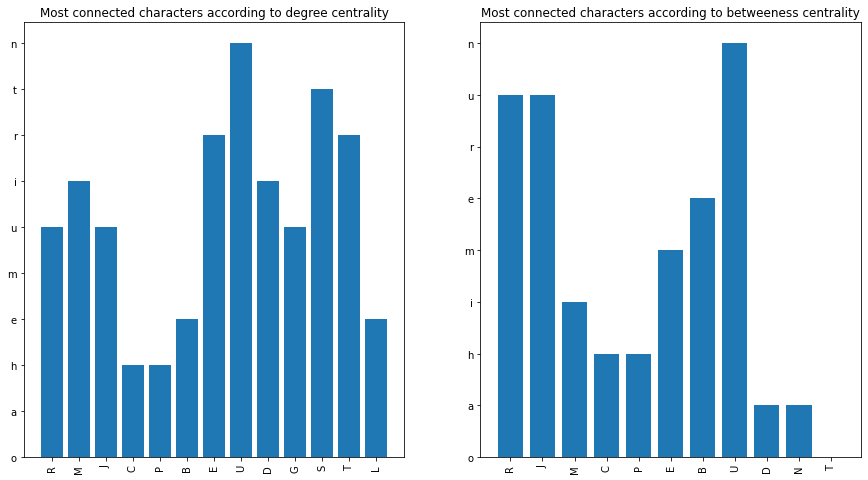

In [26]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121)
plt.xticks(rotation=90)
plt.title('Most connected characters according to degree centrality')
plt.bar([v[0] for v in top_20_centralities],[v[1] for v in top_20_centralities])
fig.add_subplot(122)
plt.xticks(rotation=90)
plt.title('Most connected characters according to betweeness centrality')
plt.bar([v[0] for v in top_20_betw_centralities],[v[1] for v in top_20_betw_centralities])

<BarContainer object of 30 artists>

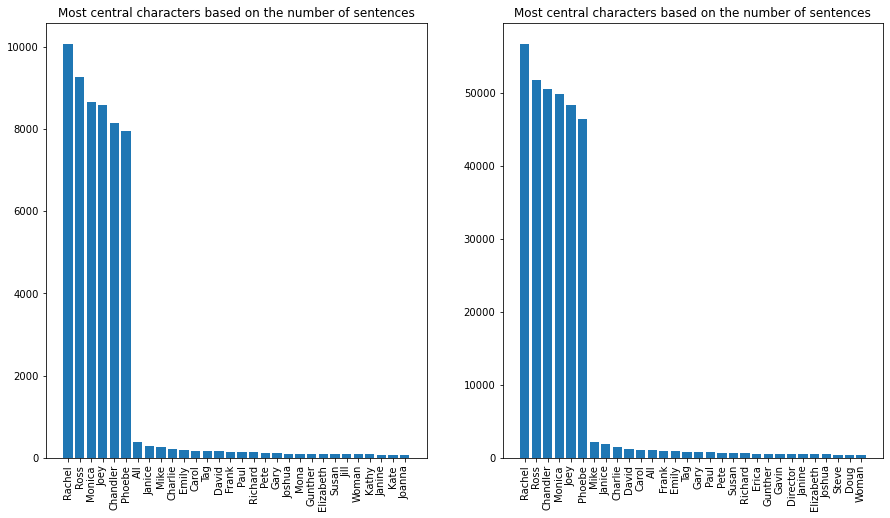

In [27]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121)
plt.title('Most central characters based on the number of sentences')
sort_sentences = lines.sort_values(by='no_sentences',ascending=False)
plt.xticks(rotation=90)
plt.bar(list(sort_sentences['Character'][:30]),list(sort_sentences['no_sentences'][:30]))

fig.add_subplot(122)
plt.title('Most central characters based on the number of sentences')
sort_words = lines.sort_values(by='no_words',ascending=False)
plt.xticks(rotation=90)
plt.bar(list(sort_words['Character'][:30]),list(sort_words['no_words'][:30]))

#### Findings

* Betweeness and degree centrality have helped us identified the most important character in the show from a scientific perspective: and that is Ross!! 
* The least connected character is Phoebe confirmed by both betweenes and degree centrality.
* In terms of the number of sentences and words spoken in the show it appears that Rachel is the winner, followed by Ross. While Monica occupies the 3rd place for the number of sentences she has ever said, the rank changes when looking at the number of words where we have Chandler on the 3rd place. While being close to the other of characters in both number of sentences and words spoken, Phoebe scores again the lowest place. We know for sure now who is the least favorite main character from the show according to network science. 

<a id='3.2.5.'></a>

#### Analysis 4: More Sentiment Analysis - for directors, episodes and pairs of characters

* Even though the directors did not seem to have any significant effect on imdb score, it is still worth investigating whether the sentiment of the show varies when the director changes. Thereby, as previously done for each individual character, the lines will be collected and analyzed for each director. The analysis will be repeated for each episode to understand if the sentiment changes over time as the characters get older and their problems become more real. 
* At the beginning of the show we have also asked ourselves: what is friends teaching us with respect to meaningful relationships? We would also like to attempt to answer this question using sentiment analysis! We have thereby collected the lines where a character is speaking about another character. By analyzing the sentiment of those we hope to understand if there is a correlation between how strong the romantic or friendship relationships and how positively these pairs talk about each other. 
* By using VADER sentiment analyzer we can attempt to offer an answer to all these questions. 

__Director Sentiment__

In [28]:
#get data
lines_and_directors = pd.read_csv('lines_directors_sentiment.csv').reset_index()
lines_and_directors = lines_and_directors[['Director','Lines']]

In [29]:
lines_dict = {}
i = 0 
#identify all episodes directed by each director and get the lines  
for director in list(lines_and_directors['Director']):
    lines_dict[director] = ast.literal_eval(lines_and_directors[lines_and_directors.Director==director]['Lines'][i])
    i = i+1

In [30]:
lines_dict_new = {}
for d in list(lines_dict.keys()):
    all_sent = lines_dict[d]
    all_sent_new = []
    for sent in all_sent:
        all_sent_new.extend(sent_tokenize(sent))
    lines_dict_new[d] = all_sent_new

In [31]:
directors_sentiment = compute_vader_sentiment(lines_dict_new)

<BarContainer object of 18 artists>

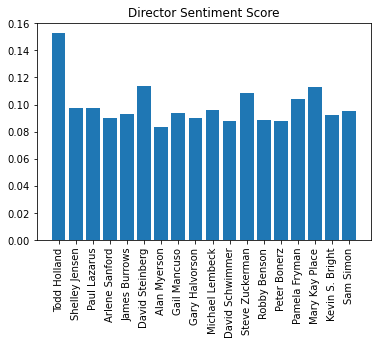

In [32]:
plt.xticks(rotation=90)
plt.title('Director Sentiment Score')
plt.bar(list(directors_sentiment.keys()),directors_sentiment.values())

* Great news! None of the directors show a negative sentiment according to the VADER analyzer. The sentiment score is pretty homogeneous across the directors with one exception: Todd Holland who has a more positive score than any other director of the show. However it should be noted that he directed only one episode in the entire show.. so maybe the data was not sufficient to make it comparable with the rest. Overall, for now we can conclude that each director transmits a positive score altough for most of them the sentiment value is mildly positive only, rarely exceeding the value of 0.10. 

__Sentiment Analysis - for pair of characters__

* In this case, all the lines for when one character mentions another character in his speech has been collected
* For each pair of characters the sentiment score has been computed using VADER
* A visual representation of the results will be generated to understand which pairs of characters speak positively about eachother 

In [33]:
ch_talk_about = pd.read_csv('edges_talkabout2.csv')

In [34]:
edges_and_sentences = {}
#find all unique pairs of characters and 
for speaker in ch_talk_about['Speaker'].unique():
    for ch in ch_talk_about['About'].unique():
        if len(list(ch_talk_about[(ch_talk_about.Speaker == speaker) & (ch_talk_about.About == ch)]['Sentence'])) > 0:
            edges_and_sentences[speaker+'_'+ ch] = list(ch_talk_about[(ch_talk_about.Speaker == speaker) & (ch_talk_about.About == ch)]['Sentence'])

In [35]:
edges_and_sentences_clean = {}
for k in list(edges_and_sentences.keys()):
    sentences = edges_and_sentences[k]
    sentences_clean = []
    for s in sentences:
        sentences_clean.extend(sent_tokenize(s.replace('\\','')))
                 
    edges_and_sentences[k] = sentences_clean

In [36]:
sentiment_towards_eachother = dict(sorted(compute_vader_sentiment(edges_and_sentences).items(), key=operator.itemgetter(1),reverse=True))

In [37]:
sentiment_of_pairs = pd.DataFrame()
sentiment_of_pairs['Character Pairs'] = list(sentiment_towards_eachother.keys())
sentiment_of_pairs['Sentiment'] = list(sentiment_towards_eachother.values())
sentiment_of_pairs.to_csv('sentiment_of_pairs.csv')

<BarContainer object of 78 artists>

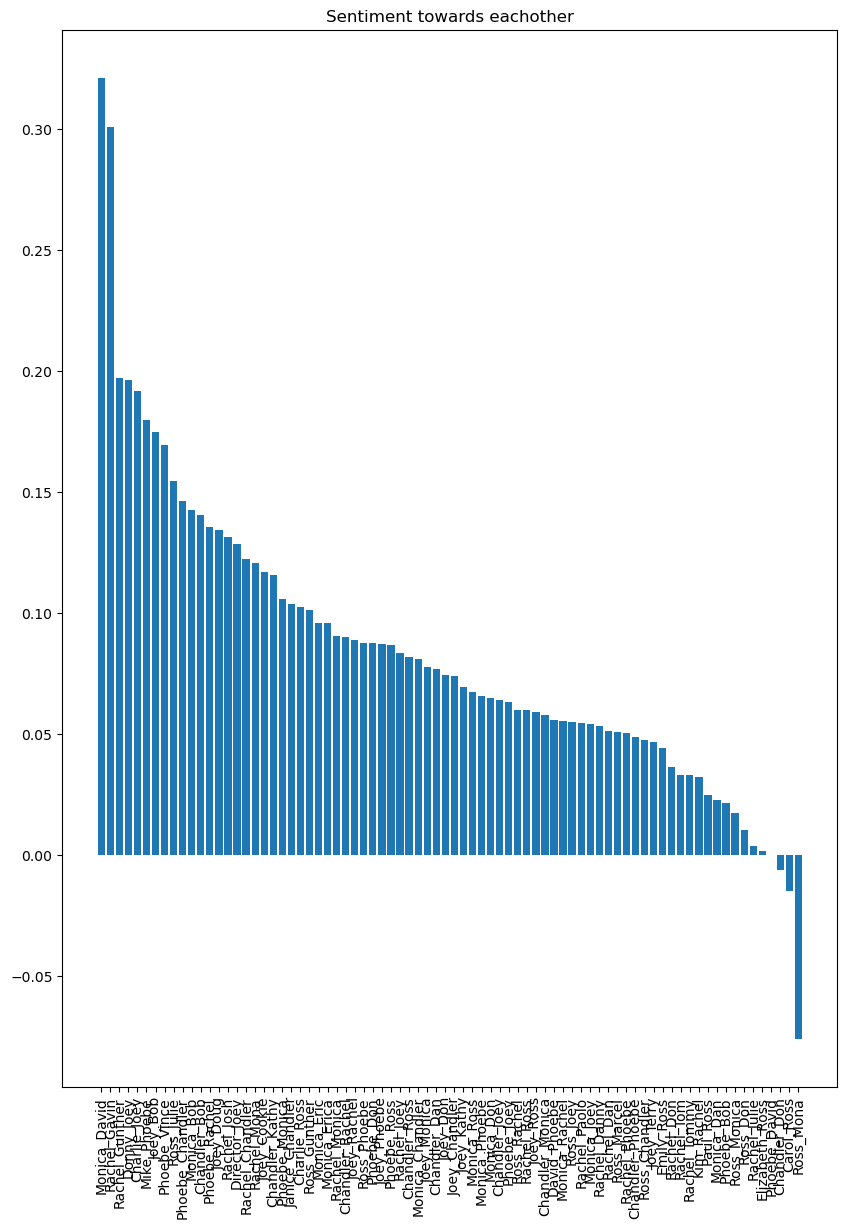

In [38]:
figure(figsize=(10,14), dpi=100)
plt.xticks(rotation=90)
plt.title('Sentiment towards eachother')
plt.bar(list(sentiment_towards_eachother.keys()),sentiment_towards_eachother.values())

__Findings__

* The pair with the highest sentiment value is Monica- David.Rachel-Gavin, Rachel- Gunther, Chandler - Joey also have high sentiment values. Rachel turns out to be very friendly with Gunther - in the rare encounter when she was actually talking to him or about him. Also, it isn't surprising giving that Mike and Phoebe have had a very smooth romantic journey - and now we can understand why - Mike is very positive towards Phoebe.
* Moreover we can see that Phoebe is very positive toward her friends in the show - Chandler, Rachel, Monica. Generally it appears that Phoebe generally is very positive towards other people - as her name appears so often in the chart. 
* At the opposite side we have Ross who appears to benegative towards Monica. Carol, Ross's ex wife appears to be neutral when speaking to or about Ross. Very diplomatic of her. 
* One can also observe from the graph that one of the friends has a neutral sentiment towards other characters like Don. 

__Eevolution of sentiment over time__

* One other interesting perspective worth to be investigated is whether there is any changes in the sentiment as the show progresses. 
* Thereby to understand this we will use - AGAIN - sentiment analysis tools to see if there an evolution or involution of the sentiment values across time. 
* The data used for this is simply the lines the characters have had in each episode of the show aggregated on an episode level. 

In [39]:
episodes_content = pd.read_csv('episodes_content.csv',encoding='UTF8').reset_index()
episodes_content = episodes_content[['Episode','Content']]

In [40]:
episodes_dict = episodes_content.set_index('Episode')['Content'].to_dict()

In [41]:
episodes_clean = {}
for k in list(episodes_dict.keys()):
    sentences = ast.literal_eval(episodes_dict[k])
    sentences_clean = []
    for s in sentences:
        sentences_clean.extend(sent_tokenize(s.replace('\\','')))
                 
    episodes_clean[k] = sentences_clean

In [42]:
episodes_sentiment = compute_vader_sentiment(episodes_clean)

In [43]:
df_directors_sentiment = pd.DataFrame()
df_directors_sentiment['Episodes'] = list(episodes_sentiment.keys())
df_directors_sentiment['Sentiment'] = list(episodes_sentiment.values())
#df_directors_sentiment.to_csv('df_directors_sentiment.csv')

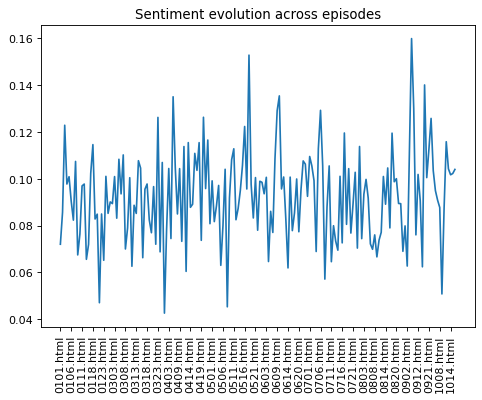

In [44]:
figure(figsize=(7,5), dpi=80)

plt.title('Sentiment evolution across episodes')
x_ticks = np.arange(0, len(episodes_sentiment), 5)
plt.xticks(x_ticks,rotation=90)
plt.plot(list(episodes_sentiment.keys()),episodes_sentiment.values())


__Findings:__
    
* The shows starts on midly positive node that increases and decreases for certain episodes throught season one.
* There are certain episodes in season 4, 5, 6 and 9 that have peak sentiment values.
* Certain other episodes are considered at most neutral by the VADER analyzer - and those belong to seasons 1,2 5 and 10. 
* For the last season one can observe a lot of ups and downs in the sentiment values which can show that there are a lot of emotions expressed as the show is approaching its end. 
* Even though certain episodes tend to be more positive than others, there are no colossal differences in the show's sentiment with very negative or very positive epsiodes. It can however be observed that some episodes are not classified as being positive according to the VADER analyzer which means that, when the epsiode sentences were analyzed and given a compound score, either there were many sentences with a negative compound score that dragged the sentiment average down or generally the compund score was low for most sentences contained in the episode. 

<a id='3.2.6.'></a>
#### Word clouds

__Creation process__

_The creation of the word clouds is done in the following way:_

1. _We have aggregated the content of all story lines for each of the 6 friends into text files. The files are placed in the "content" folder_.

2. _We calculate the word IDF across the 6 friends text files. IDF is not specific for each friend_.

3. _Then we calculate TC, which is the Term Count, for each word for each friend. TC is specific for each friend. TC does not take the length of the text into account. This is opposit to TF_.

4. _We combine the IDF and the TC into IDF-TC for each race. Which gives us a list of words that is most notable for each friend_.

5. _Each word list for each friend is used to generate a Word Cloud. The largest word in each Word Cloud is the most notable word for that friend. E.g. In the Chandler Word Cloud "pride" appears as a large word, because it is specific for Chandler_.

6. _Finally we write the 100 most notable words for each of the friends to the characterwords.csv file._



In [45]:
content_path = "Content"
content_files = [f for f in listdir(content_path) if isfile(join(content_path, f))]

# Calculate IDF for words across all races
wordlist = nltk.corpus.PlaintextCorpusReader(content_path,content_files)

mytext = nltk.TextCollection(wordlist)
idf_dict = {}
for word in np.unique(wordlist.words()):
    idf_dict[word] = mytext.idf(word)

In [ ]:
friends_tc = {}
friends_tc_idf = {}
champions = ["Chandler","Joey", "Monica", "Phoebe", "Ross", "Rachel"]

for champion in champions:
    wordlist = nltk.corpus.PlaintextCorpusReader(content_path,champion + ".txt")
    txt_obj = nltk.Text(wordlist.words())
    tc_dict = {}

    for key, value in nltk.FreqDist(txt_obj).items():
        tc_dict[key] = value

    friends_tc[champion] = tc_dict

    tc_idf_dict = {}

    # calcute TC-IDF
    for word in tc_dict:
        tc = tc_dict[word]
        idf = idf_dict[word]
        tc_idf = tc * idf
        tc_idf_dict[word] = tc_idf

    friends_tc_idf[champion] = tc_idf_dict

In [ ]:
# Write character words to csv

character_wordsList = []

for champion in champions:

    champion_friends_tc_idf = friends_tc_idf[champion]
    sorted_champion_friends_tc_idf = sorted(champion_friends_tc_idf.items(), key=lambda kv: kv[1], reverse=True)

    wordcloud_string = ""
    
    for word in sorted_champion_friends_tc_idf[:100]:
        w = word[0]
        wordcloud_string += w + " "

    character_wordsList.append((champion,wordcloud_string))

# Write nodes to csv
df_characters_words = pd.DataFrame(character_wordsList)
df_characters_words.columns = ['Name','Words']

# Write the list of chracters to a CSV file, without the index column
wordlistPath = "characterwords.csv"
df_characters_words.to_csv(wordlistPath, index=False)

In [ ]:
# Read words for characters from CSV
df_wordlist = pd.read_csv(wordlistPath)

colormapList = [
        'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

for champion_row in df_wordlist.iterrows():
    #print(champion_row)
    champion = champion_row[1][0]
    #print(champion)
    wordcloud_string = champion_row[1][1]
    #print(wordcloud_string)

    # Create and generate a word cloud image:
    colormap = random.choice(colormapList)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white', colormap=colormap).generate(wordcloud_string)
    wordcloud.collocations = False

    # Display the generated image:
    plt.figure( figsize=(15,7))
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(champion,fontsize=15)
    plt.show()

__Findings__

## Discussion

__What went well?__

Friends it is a network that was worth investigating using scientific methods like sentiment analysis and degree centrality, 
which some new insights into the Friends universe. The sentiment values found have helped categorize the characters as being positive, neutral or negative. Moreover this has also helped us study the relationships in the show as well as the evolution of the sentiment trought the seasons. The ANOVA analysis has helped us conclude that no significant effect of the directors of the show exists on the imdb score. 

The data retrivial using regex and the storing of preprocessed data in csv has also worked well. The csv files was easy to use in the Streamlit website.


__What can be improved?__

* Altough the sentiment anaylsis - which represented a central tool for this project has proven to be useful and helped us get new insights - there is more that can be investigated. Given that Friends is a sitcom, and some of the magic of the show lies in the sarcastic dialogue of the characters, using machine learning to identify sarcasm could have been a great addition to the project. 

* Moreover, even though the superfans would strongly disagree with this, there are many communities on the internet that are not so fond of the Friends show and that consider that some of the scenes and jokes have not aged well, as the world is going towards a more progressive and inclusive direction. Thereby by extracting data from Twitter for example one could analyze what is the sentiment among young people who are currently watching the show versus the older generation. 

* A sentiment evolution of the main characters over time would have also been useful in investigating why certain relationships faded off like Monica and Richard and some others blossomed like Phoebe and Mike. 

* In conclusion there are endless possibilities for analyses that can help get new insights into the show and can potentially be used as reference for current shows that whish to maintain their popularity in the future. For this however more time and knowledge is needed in order to carry meaningful analyses. 

## Contributions


* Project Assignment A:

-  _Viktor_ : Video Production
- _Basic Stats_ : Mihaela 
-  _Project Plan_ : Jacob 

Project Assignment B:

* Analyses:

 - _Mihaela:_ Analysis 1, Analysis 2, Analysis 3, Analysis 4.
 - _Jacob_: TF-IDF and Wordclouds

* Data:

- _Jacob_ : Data retrieval, Data Cleaning and Data Processing.
- _Mihaela_ : Data Processing - small part. 

* Website: 

- _Jacob_ : Website Setup, ForceAtlas graph, Wordclouds, Data Story. 
- _Mihaela_: Sentiment graphs, Degree and betweenness centrality graphs, Data Story. 
- _Viktor_: Interractive Network Visualizations, Data Story. 

* Report Writing:

- _Mihaela_: Motivation, Analyses, Conclusion
- Jacob : Data Gathering and Processing, Network Statistics 


<a id='6.'></a>
## References

1. http://networksciencebook.com/
2. https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664#:~:text=VADER%20sentimental%20analysis%20relies%20on,each%20word%20in%20the%20text.
3. https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/
4. https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php
5. https://neo4j.com/docs/graph-data-science/current/algorithms/betweenness-centrality/#:~:text=Betweenness%20centrality%20is%20a%20way,of%20nodes%20in%20a%20graph.
6. https://en.wikipedia.org/wiki/Centrality

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aee39066-d006-4842-a0e1-46c68e5ff786' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>